# Geosilhouettes: geographical measures of cluster fit

[Silhouette statistics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html) ([Rousseeuw, 1987](https://doi.org/10.1016/0377-0427(87)90125-7)) are a nonparametric measure of an observation's goodness of fit to a given cluster. Where clusters have a *geographical* interpretation, such as when they represent geographical regions, silhouette statistics can incorporate *spatial thinking* in order to provide more useful measures of cluster fit.   The [paper by Wolf, Knaap, & Rey (2019)](https://doi.org/10.1177%2F2399808319875752).
([preprint on SocArXiv](https://osf.io/preprints/socarxiv/vd3uk/)) defines two:

1. **Path Silhouettes**, which characterize the joint geographical and feature similarity in a clustering.
2. **Boundary Silhouettes**, which characterize how well-defined a geographical boundary is in a clustering. 

Together, these two new measures provide new ways to measure the goodness of fit of clusters in clustering problems in geographic data science. 

Below, we'll dig a little into how these are implemented in the `esda` package. First, though, let's set up some data. We'll be considering a single *univariate* dataset, the Gini index in 1989 in counties for the US Deep South.

In [1]:
import libpysal
import numpy
import esda
import geopandas
import contextily
import matplotlib.pyplot as plt
%matplotlib inline

To focus in on only the deep south, we'll build an array of states that fall within the deep south:

In [2]:
focus_states = ["Alabama", "Georgia", "Louisiana", 
                "Mississippi", "South Carolina"]

Then, we'll read in data for all of the south, using the example datasets in the `libpysal` package:

In [3]:
south = geopandas.read_file(libpysal.examples.get_path('south.shp'))

Then, we'll filter out only the states in the deep south:

In [4]:
deep = south.query('STATE_NAME in @focus_states').reset_index()

In [5]:
deep['state_label'] = deep.STATE_NAME.apply(lambda x: focus_states.index(x))

Finally, for mapping purposes, let's get a basemap. This is done using the `contextily` package, which expects our data in a specific coordinate projection system. For more, check out the [`contextily` user guide](https://github.com/darribas/contextily/blob/master/contextily_guide.ipynb). 

In [6]:
deep.crs = {'init':'epsg:4326'}

In [7]:
deep = deep.to_crs(epsg=3857)

In [8]:
basemap, extent = contextily.bounds2img(*deep.total_bounds, zoom=6,
                                        url=contextily.tile_providers.ST_TONER_LITE)

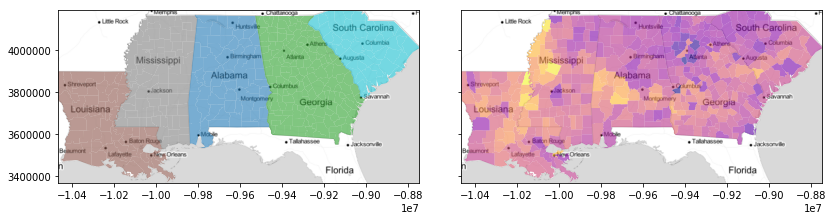

In [9]:
f,ax = plt.subplots(1,2, figsize=(12,3), sharex=True, sharey=True)
deep.plot('STATE_NAME', ax=ax[0], alpha=.6)
deep.plot('GI89', ax=ax[1], cmap='plasma', alpha=.6)
for ax_ in ax:
    ax_.imshow(basemap, extent=extent, interpolation='bilinear')
    ax_.axis(deep.total_bounds[[0,2,1,3]])
f.tight_layout()
plt.show()

# The Silhouette Score

The standard silhouette score used in classification/grouping problems as measure of how well-fit an observation is to its current group. The measure is fairly robust, well-studied, and is common in many different problem areas. 

Statistically, the silhouette score is composed of a few components: 
- $c$, the cluster in which $i$ is assigned
- $k$, another cluster in which $i$ is not currently assigned
- $d_i(c)$: the dissimilarity between observation $i$ and $i$'s own cluster $c$
- $d_i(k)$: the dissimilarity between observation $i$ and a cluster $k$ that $i$ is not in. 

Here, we define $d$ as an arbitrary dissimilarity metric. For most cases, it's normally the euclidean distance. So, if you see $d_i(c)$, this is the average dissimilarity between observation $i$ and all other observations $j$ in cluster $c$. 

Then, we need to define the *second best choice cluster*, $\hat{k}$, which is a cluster that $i$ is most similar to, but of which $i$ is not currently a member:
$$\hat{k}_i = k\ | \min_k \{d_i(k)\}$$

This lets us define the silhouette score as the relationship between the dissimilarity scores for $i$ and its cluster $c$, and $i$ and the second-best choice cluster, $\hat{k}$:
$$ s_i = \frac{d_i(c) - d_i(\hat{k})}{\max\left\{d_i(c), d_i(\hat{k})\right\}}$$

This value is close to 1 when $i$ is much closer to its current cluster, $c$, than the second-best cluster, $\hat{k}$, indicating strong fit to its current cluster. And, when $i$ is more similar to $\hat{k}$ than to its own cluster $c$, the value of $s_i$ is close to -1. We can compute the score for each observation using `sklearn`'s `silhouette_samples`:

In [10]:
from sklearn.metrics import silhouette_samples
silhouettes = silhouette_samples(deep[['GI89']].values, deep.state_label)

Here, we can visualize the silhouette scores by county. With this information, we can see that there is very strong heterogeneity in the Gini coefficient *within* states, because the silhouette statisic for each county is usually negative (i.e. blue). But, in some areas (e.g. areas of South Carolina and Louisiana), the silhouette statistics for counties are positive (red), suggesting those counties are well-fit to their surroundings. 

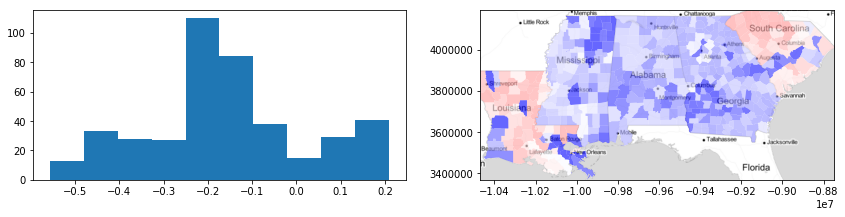

In [11]:
f,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(silhouettes)
deep.plot(silhouettes, ax=ax[1], cmap='bwr', 
          vmin=-.5, vmax=.5, alpha=.6)
ax[1].imshow(basemap, extent=extent, interpolation='bilinear')
ax[1].axis(deep.total_bounds[[0,2,1,3]])
f.tight_layout()
plt.show()

On the contrary, if we used a *data-driven* definition of regions, we might expect the silhouette scores to be more positive. For example, if we used $k$-means to define the *best* data-driven groups we could have for this data, we might have something like this:

In [12]:
from sklearn.cluster import KMeans
data_driven_clustering = KMeans(n_clusters=len(focus_states)).fit(deep[['GI89']].values)
data_labels = data_driven_clustering.labels_
data_silhouettes = silhouette_samples(deep[['GI89']].values, 
                                      data_labels)

This yields the following geography of inequality in the deep south:

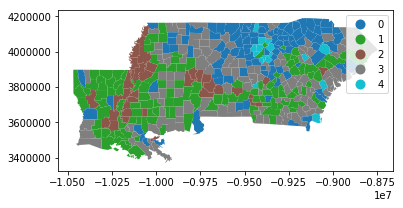

In [13]:
deep.plot(data_labels, categorical=True, legend=True)
plt.show()

And, in this geography of inequality, each county is very well fit to its group:

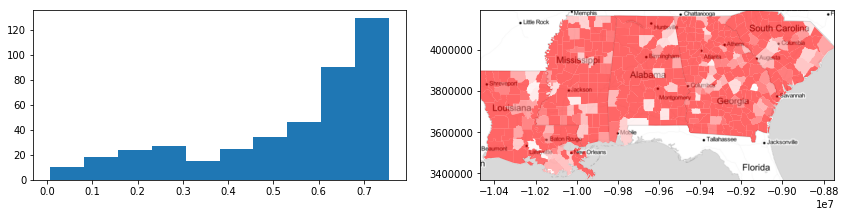

In [14]:
f,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(data_silhouettes)
deep.plot(data_silhouettes, ax=ax[1], cmap='bwr', 
          vmin=-.5, vmax=.5, alpha=.6)
ax[1].imshow(basemap, extent=extent, interpolation='bilinear')
ax[1].axis(deep.total_bounds[[0,2,1,3]])
f.tight_layout()
plt.show()

# Nearest Label

Fundamental to the measurement of the silhouette score is the idea of a *next best fit cluster*. This is $\hat{k}_i$, the cluster to which $i$ *would* be assigned if it were not in its current cluster, $c$. This is a useful concept, because it shows the latent relationship between observations and other clusters. It gets at how the clustering *might* be different if different decisions about grouping/classification had been made, and helps us construct a measure of how much "better" $c$ currently is for $i$ than $\hat{k}_i$ would be. 

But, by default, `scikit-learn` does not provide you with $\hat{k}_i$. Instead, it only provides $s_i$. So, `esda` provides this for you in the `nearest_label` function:

In [15]:
nearest_label = esda.nearest_label(deep[['GI89']].values, deep.state_label)

/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


With this function, you can visualize the geography of the *second-best choice*, $\hat{k}_i$. For example, most of the south of Alabama and Georgia and the [Mississippi Delta region](https://en.wikipedia.org/wiki/Mississippi_Delta) has a "second choice" similarity to the inequality profile of Louisiana. This means that, if these counties *were not* in their own states, they'd be most similar to counies in Louisiana. 

However, keep in mind that this idea of a *second choice* excludes $c_i$ from the potential list of *nearest labels*!

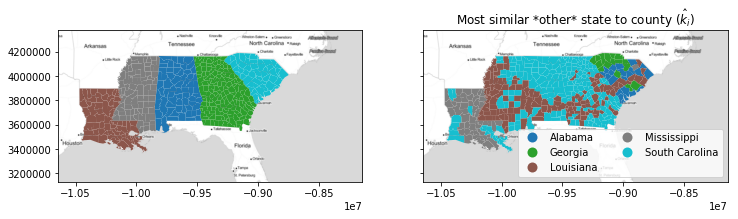

In [16]:
nearest_outside_state = numpy.asarray(focus_states)[nearest_label]
f, ax = plt.subplots(1,2,figsize=(12,4), sharex=True, sharey=True)
deep.plot('STATE_NAME', ax=ax[0], categorical=True)
deep.plot(nearest_outside_state, ax=ax[1],
               legend=True, categorical=True, 
               legend_kwds=dict(loc='lower right', ncol=2))
ax[1].set_title('Most similar *other* state to county ($\hat{k}_i$)')
for ax_ in ax:
    ax_.imshow(basemap, extent=extent, interpolation='bilinear')

To allow for this, the `keep_self` argument modifies `nearest_label` to return the nearest label out of *any* group, regardless of whether or not the observation is currently in that group. This means that the *nearest alternative label* is provided by `nearest_label`, but the *absolute nearest label* is provided by `nearest_label(data, labels, keep_self=True)`. 

These two can be quite different. Below, you can see that the similarities definitely shift when we allow observations' nearest labels to be their *current* classification. There, we see that most counties are either more similar to Louisiana, or they're more similar to South Carolina. Forcing the return of the *nearest alternative label* caused Mississippi to be included as the second choice of most of the counties in Louisiana, and for Alabama & Georgia to be given the second choice of many counties in South Carolina. 

/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


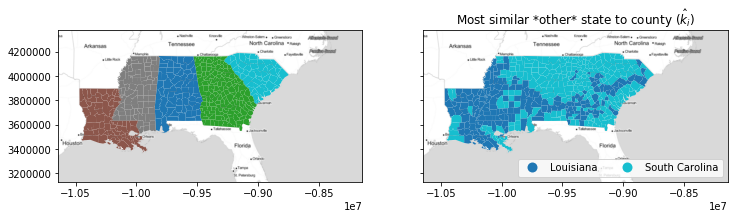

In [17]:
nearest_label = esda.nearest_label(deep[['GI89']].values, 
                                   deep.state_label, keep_self=True)
nearest_state = numpy.asarray(focus_states)[nearest_label]
f, ax = plt.subplots(1,2,figsize=(12,4), sharex=True, sharey=True)
deep.plot('STATE_NAME', ax=ax[0], categorical=True)
deep.plot(nearest_state, ax=ax[1],
               legend=True, categorical=True, 
               legend_kwds=dict(loc='lower right', ncol=2))
ax[1].set_title('Most similar *other* state to county ($\hat{k}_i$)')
for ax_ in ax:
    ax_.imshow(basemap, extent=extent, interpolation='bilinear')

# Geographical Structure

For many geographical analysis algorithms, we require some sense of geographical structure in order to "understand" geography. At its most basic level, this requires us to define a representation of geography that can be used in analysis. Often, this takes the form of a [*graph*, or *network*](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)), that links observations. In this mode of analysis, each *node* is an observation and each *edge* represents a geographic connection between observations. 

The `pysal`/`libpysal` libraries contain many tools for building graphs from geographical data. In these domains, it is common to refer to one representation of the geographical graph as a *spatial weights matrix*, since it reflects the *spatial weight* each observation has on every other observation. As such, this is stored in the `libpysal.weights` module. 

Here, we'll construct the [Rook Contiguity graph](https://gis.stackexchange.com/questions/172998/queen-vs-rook-neighborhood) (sometimes called the [von Neuman neighborhood](https://en.wikipedia.org/wiki/Von_Neumann_neighborhood)) for counties using the `libpysal.weights.Rook` constructor:

In [18]:
w = libpysal.weights.Rook.from_dataframe(deep)

To see what this looks like, we can plot the graph below, where "connected" counties have a black line drawn between their centers:

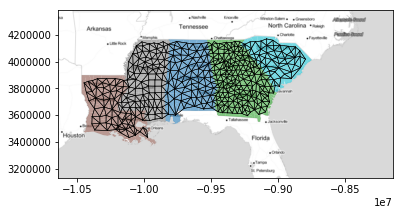

In [19]:
f,ax = w.plot(deep, edge_kws=dict(linewidth=.5), 
              node_kws=dict(s=0))
deep.plot('STATE_NAME', ax=ax, alpha=.6)
ax.imshow(basemap, extent=extent, interpolation='bilinear')
plt.show()

# Path Silhouettes

The path silhouette models the joint geographical and feature dissimilarity between two observations as a *joint* spatial and social similarity: 

$$ d(i,j) = d_f(i,j) * d_s(i,j)$$

where $d_f(i,j)$ is the dissimilarity between the *features* for observations $i$ and $j$ and $d_s(i,j)$ is the *spatial* dissimilarity between sites $i$ and $j$. Often $d_s(i,j)$ is measured by the euclidean distance matrix between all pairs of sites, but this can sometimes include inaccurate or mis-representative information about distances for some kinds of spatial data. Therefore, the *path* silhouette uses a $d_s$ that computes the total pairwise dissimilarity for a *path* connecting $i$ and $j$. 

For the full distance matrix, this *path* dissimilarity between sites $i$ and $j$ reduces simply to the dissimilarity between sites $i$ and $j$, multiplied by the dissimilarity between sites $i$ and $j$. When $d_s$ is *not* the full distance matrix, $d_f(i,j) * d_s(i,j)$ is modeled as the length of the shortest path connecting sites $i$ and $j$. This path may include *other* intermediate sites, such that the whole path cost is the *sum* of the links on the shortest path from $i$ to $j$. For instance, if the shortest path from $i$ to $j$ is built from additional links $i \rightarrow l \rightarrow m \rightarrow j$, then the path cost representing $d(i,j)$ is:

$$ d(i,j) = d_f(i,l) * d_s(i,l) + d_f(l,m) * d_s(l,m) + d_f(m,j) * d_s(m,j)$$

This *path metric* is common in geographical analysis problems, but provides a useful insight into the joint geographical-feature similarity of observations & groups. Then, with this $d$, the silouette is computed identically. 

In `esda`, this is done using the spatial weights object we built before, in addition to the same data and labels we used before for the classical silhouette:

In [20]:
path_silhouette = esda.path_silhouette(deep[['GI89']].values, 
                                       deep.state_label, w)

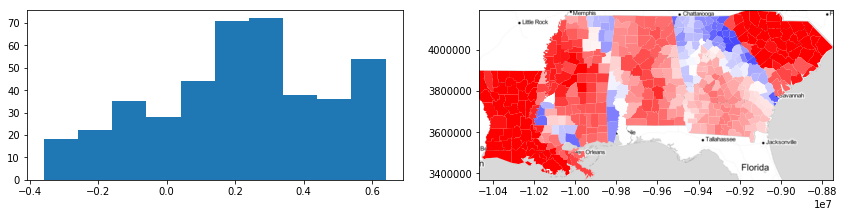

In [21]:
f,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(path_silhouette)
deep.plot(path_silhouette, ax=ax[1], cmap='bwr', vmin=-.5, vmax=.5)
ax[1].imshow(basemap, extent=extent, interpolation='bilinear')
ax[1].axis(deep.total_bounds[[0,2,1,3]])
f.tight_layout()
plt.show()

With this, we see that *most* path silhouetes are positive, but some (especially on the boundaries between similar states) are negative. Further, we see that the two states surfaced in the traditional silhouette analysis (Louisiana and South Carolina) are *again* strongly path-similar, meaning they're both geographically distinctive and homogenous in their inequality profiles. 

There is much additional output available from the `path_silhouette` function, but one useful output provides the path equivalent of `nearest_label`: the next best fit cluster under the path metric. To access this, pass `return_nbfc=True` to the `path_silhouette` function:

In [22]:
path_silhouette, next_best_path = esda.path_silhouette(deep[['GI89']].values, 
                                                       deep.state_label, w, 
                                                       return_nbfc=True)

Intuitively with this, we see that the *path* similarity can enforce a strong spatial structure in the second choice cluster plots. For instance, the "end" states (Louisiana and South Carolina) have basically no choice other than their closest state. But, the middle three states are split quite neatly in half between their neighbors. 

However, together these combine in the silhouette plot to produce rather remarkable patterns in terms of joint geographical and feature similarity! The patterns don't strictly follow the boundaries. Indeed, the negative path silhouettes in north Georgia (largely driven by similarities within the Atlanta-Athens suburbs) and the positive areas completely disregard the divisions in the path-similar map. This suggests that this similarity changes smoothly over geography, even when the "reference" category does not. 

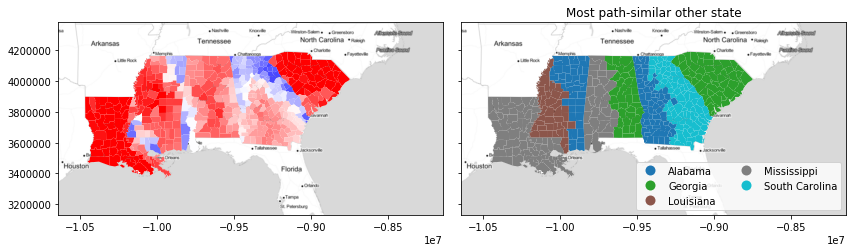

In [23]:
next_best_path_state = numpy.asarray(focus_states)[next_best_path]
f, ax = plt.subplots(1,2,figsize=(12,4), sharex=True, sharey=True)
deep.plot(path_silhouette, ax=ax[0], cmap='bwr', vmin=-.5, vmax=.5)
deep.plot(next_best_path_state, ax=ax[1],
               legend=True, categorical=True, 
               legend_kwds=dict(loc='lower right', ncol=2))
ax[1].set_title('Most path-similar other state')
for ax_ in ax:
    ax_.imshow(basemap, extent=extent, interpolation='bilinear')
f.tight_layout()
plt.show()

# Boundary Silhouettes

The final measure of geographical similarity using silhouette statistics constraints the silhoutte "second choice" clusters to make geographical "sense." By this, consider the map of second-choice clusters from the classic silhouette again:

/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


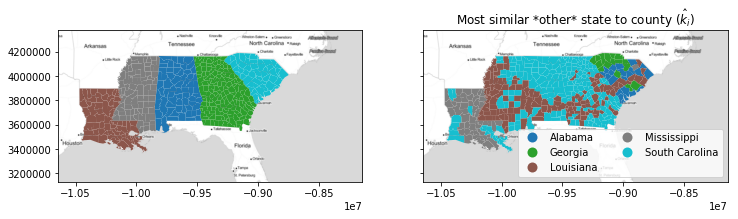

In [24]:
nearest_label = esda.nearest_label(deep[['GI89']].values, deep.state_label)
nearest_outside_state = numpy.asarray(focus_states)[nearest_label]
f, ax = plt.subplots(1,2,figsize=(12,4), sharex=True, sharey=True)
deep.plot('STATE_NAME', ax=ax[0], categorical=True)
deep.plot(nearest_outside_state, ax=ax[1],
               legend=True, categorical=True, 
               legend_kwds=dict(loc='lower right', ncol=2))
ax[1].set_title('Most similar *other* state to county ($\hat{k}_i$)')
for ax_ in ax:
    ax_.imshow(basemap, extent=extent, interpolation='bilinear')

In this case, there are many counties in South Carolina whose "second choice" is all the way over in Louisiana! This is unrealistic, since these observations can't really plausibly be grouped with Louisiana counties in a geographical sense. To account for this, we restrict our attention only to counties that have a *feasible* second choice, meaning they could "flip" over to the other group without becoming isolated.

This automatially restricts our attention to the *border* counties, those that touch another state. For a boundary silhouette, all "interior" observations, those that are *not* touching an observation in another group, have a default value of zero for their boundary silhouette. All others constrain $\hat{k}_i$ to be a cluster that $i$ *is near*, geographically. With this constraint, the rest of the silhouette is computed as normal. 

To show what this looks like, we can use the `esda.boundary_silhouette` function:

In [25]:
boundary_silhouette = esda.boundary_silhouette(deep[['GI89']].values, 
                                               deep.state_label, w)
deep['boundary_silhouette'] = boundary_silhouette

For this, the *vast* majority of the observations are not on borders between states, so most boundary silhouettes are zeros:

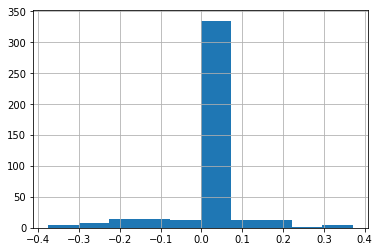

In [26]:
deep.boundary_silhouette.hist()

So, it often makes sense to consider these "structural" zeros separately from the observations that are *actually* on the boundary:

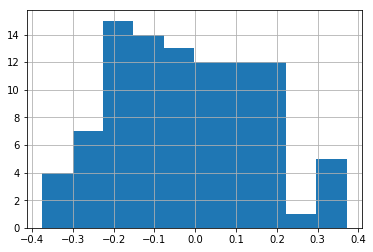

In [27]:
deep.query('boundary_silhouette != 0').boundary_silhouette.hist()

These observations are negative when a *boundary* county is more similar to the state on the *other side of the boundary* than it is to its own state. They are positive when a county is more similar to its own state than it is for the other state on the other side of the boundary. 

Visualizing this silhouette, it helps to separate out the zeros again:

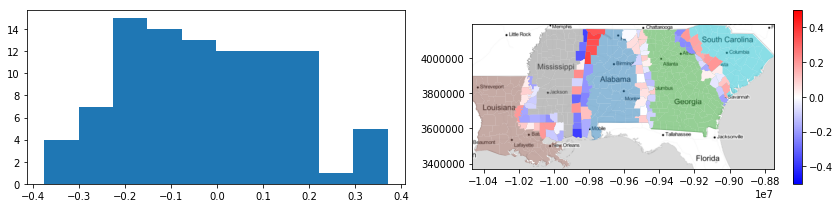

In [28]:
f,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(deep.query('boundary_silhouette != 0').boundary_silhouette)
deep.plot('STATE_NAME', ax=ax[1], alpha=.5)
deep.query('boundary_silhouette != 0')\
    .plot('boundary_silhouette', ax=ax[1], cmap='bwr', 
          vmin=-.5, vmax=.5, legend=True)
ax[1].imshow(basemap, extent=extent, interpolation='bilinear')
ax[1].axis(deep.total_bounds[[0,2,1,3]])
f.tight_layout()
plt.show()

From this, you can see things like:
- All the tracts on the Mississippi-Louisiana border have more similar Gini values to those in Louisiana. 
- North and South Alabama differ significantly in their similarities to Mississippi; in the north, boundary tracts are much more "Alabaman" than in the south. 
- The boundary between Alabama and Georgia is quite weak; most of the silhouttes are very close to zero, suggesting the dissimilarity in this area is rather gradual, and that the border tracts between the two are quite similar to either Alabama or Georgia. 

# Conclusion

Overall, silhouette statistics are useful in the analysis of clustering and similarity. However, in geographical applications, it sometimes becomes important to understand the *geographical* structure of groups, in addition to the feature structure explored by silhouette statistics. So, two new silhouette statistics are proposed in Wolf, Knaap, and Rey (2019):

1. The path silhouette, which measures the joint feature & geographical similarity.
2. The boundary silhouette, which measures the similarity of *boundaries* between groups. 

Both have distinct uses, and do not supersede the silhouette statistic. Rather, they are spatial complements that provide different information about the geographical structure of groups in clustering problems. 